Dataset Pequeno - https://www.kaggle.com/returnofsputnik/chihuahua-or-muffin

Dataset Grande - https://www.kaggle.com/ingrid2/moffinorchihuahua

In [1]:
#!pip install opencv-contrib-python

In [26]:
from os import listdir
from os.path import isfile, join
import numpy as np
import cv2
from utils import *

np.random.seed(42)

def load_data(base_path="data/chihuahuaVSmuffin/small", 
              chihuahuas_folder = "chihuahua", 
              muffins_folder = "muffin", 
              gray_scale=False,
             size=(32,32)):
    chihuahuas = load_images_from_folder(join(base_path, chihuahuas_folder), gray_scale, size)
    muffins = load_images_from_folder(join(base_path, muffins_folder), gray_scale, size)
    
    print(f"Carregadas {len(chihuahuas)} imagens de chihuahuas e {len(muffins)} de muffins")
    return {"chihuahuas": chihuahuas, "muffins": muffins}

size = (64,64)
data = load_data(base_path="data/chihuahuaVSmuffin/big",size=size)

Carregadas 279 imagens de chihuahuas e 273 de muffins


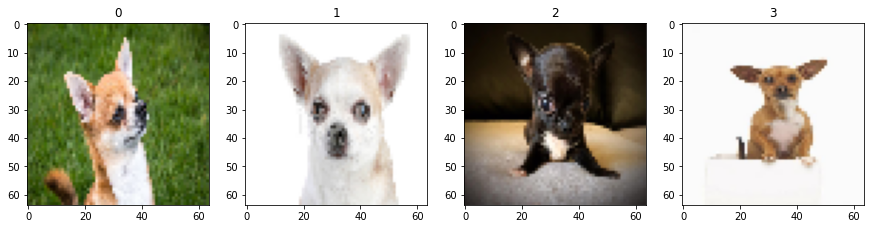

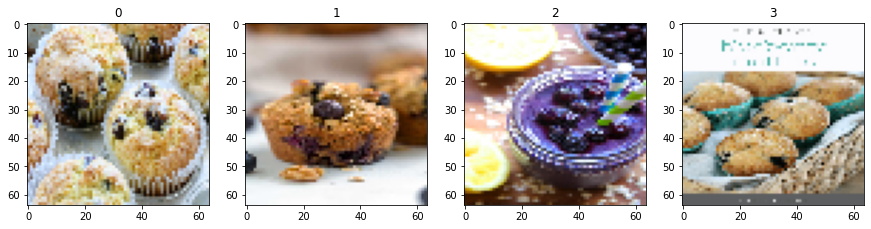

In [27]:
%matplotlib inline
        
plot_images(data["chihuahuas"][:4], rows=1)
plot_images(data["muffins"][:4], rows=1)

In [28]:
def process_data(data):
    X = np.vstack((images_to_2d(data["chihuahuas"]),images_to_2d(data["muffins"])))
    Y = np.array(["chihuahua" for _ in data["chihuahuas"]] + ["muffin" for _ in data["muffins"]])
    
    return X, Y


X,Y = process_data(data)
X.shape, Y.shape

((552, 12288), (552,))

In [29]:
from sklearn.model_selection import train_test_split

Y_numeric = np.zeros(len(Y), dtype=int)
Y_numeric[Y == "chihuahua"] = 1

X_train, X_test, Y_train, Y_test = train_test_split(X,Y_numeric, test_size=0.2, random_state=42)

In [30]:
from models import PPCA
ppca = PPCA(100)
ppca.fit(X_train)

z = ppca.project(X_train)
x = ppca.reconstruct(z)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


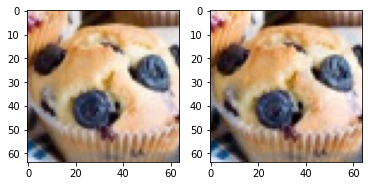

In [19]:
plt.subplot(1,2,1)
plt.imshow(vector_to_image(X_train[0], size))
plt.subplot(1,2,2)
plt.imshow(vector_to_image(x[0], size))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


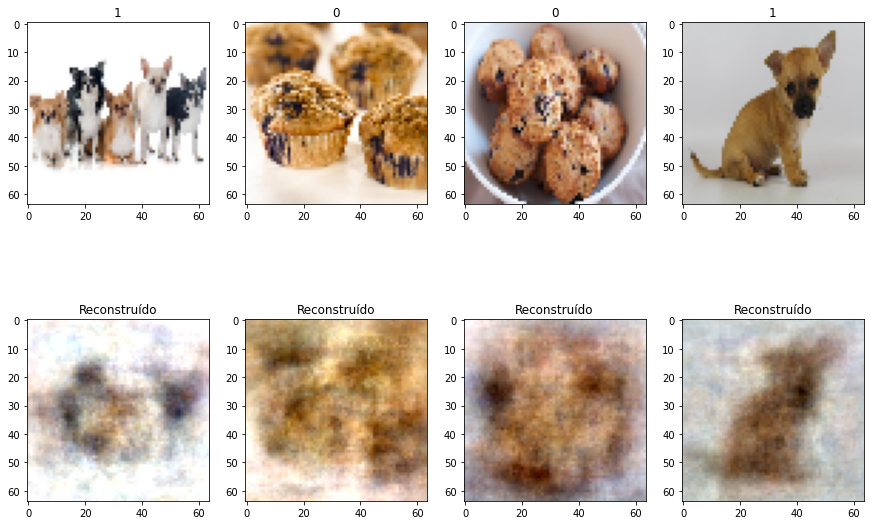

In [31]:
from sklearn.utils import resample

num_samples = 4
samples = resample(X_test, Y_test, n_samples=num_samples, replace=False)

fig = plt.figure(figsize=(15,10))
for n, (img, label) in enumerate(zip(samples[0], samples[1])):
    reconstruct = ppca.reconstruct(ppca.project(img))
    
    plt.subplot(2, num_samples, n+1)
    plt.title(label)
    plt.imshow(vector_to_image(img, size))
    
    plt.subplot(2, num_samples, n+num_samples+1)
    plt.title("Reconstruído")
    plt.imshow(vector_to_image(reconstruct, size))
    
plt.show()

In [32]:
from models import LogisticRegression
model = LogisticRegression()
model.fit(z, Y_train)

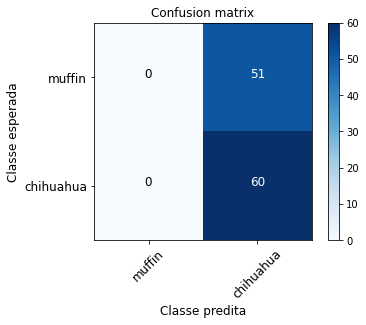

In [33]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize: # a normalização é usada para saber a porcentagem de acerto por classe
        cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])
        nan_indexes = np.isnan(cm)
        cm[nan_indexes] = 0

    plt.figure()
    plt.rcParams["axes.grid"] = False
    plt.imshow(cm, cmap=cmap)

    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                fontsize=12)

    plt.ylabel('Classe esperada', fontsize=12)
    plt.xlabel('Classe predita', fontsize=12)
    

cm = confusion_matrix(Y_test, model.predict_probit(ppca.project(X_test)))
plot_confusion_matrix(cm, ["muffin","chihuahua"], normalize=False)

In [34]:
print("Acurácia: ",cm.diagonal().sum()/cm.sum())

Acurácia:  0.5405405405405406
